In [1]:
import numpy as np
import pandas as pd
import speechpy
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.lib.display import Audio
from IPython.display import display
import os
from hmmlearn import hmm
import warnings
from pydtw import dtw2d
import scipy
# Lots of warnings appear in the hmm routines to note the future change of some inner functions,
# I chose to ignore them because it is not relevant for the viewer.
warnings.filterwarnings("ignore")

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# English Accents classification
## Introduction
This dataset is composed of 15 speakers, 20 audio files per speaker. Those speakers were randomly selected from the **[VCTK Corpus](http://homepages.inf.ed.ac.uk/jyamagis/page3/page58/page58.html)**. Because of the size of the Corpus, The random selection was made on another computer and is hence not visible in this jupyter notebook. The file *random_files_selector.py* holds the code doing the selection. The speech data was recorded using an identical recording setup: an omni-directional head-mounted microphone (DPA 4035), 96kHz sampling frequency at 24 bits and in a hemi-anechoic chamber. All recordings were converted into 16 bits, were downsampled to 48 kHz based on STPK, and were manually end-pointed. 

**The goal of this notebook is to classify accents using mfcc features.** In order to do so, we will construct a graph of similarity and try to find clusters. We will use Hidden Markov Models as our temporal pattern classifier which is famous in speech recognition. Then we will try traditional classifiers, a simple neural network and a convolutional neural network. As we will attempt to classify 15 accents, the baseline accuracy will be 1/15 = 6.6%.


# Structure of the notebook :
## 0. Getting a taset of the accents
## 1. Load files and preprocess data
## 2. Hidden Markov Model classification
## 3. Reducing dimensionallity of the data into a statistical subspace
## 4. Try basic PCA separation
## 5. Spectral graph clustering
- 5.1 Compute the distance matrix between all spoken sentences
- 5.2 Gaussian kernel and sparsification of the similarity matrix
- 5.3 Compute Laplacian
- 5.4 Get eigenvectors of the laplacian
- 5.5 Cluster the accents 

## 6. Traditional classifiers
- 6.1 Shuffle the data and split it into a training and a testing set
- 6.2 Classify with a 5fold cross-validation

## 7. Classification using Neural Networks
- 7.1 Simple multi layer perceptron
- 7.2 Classification with convolutional neural networks

## Conclusion
- What could be done to increase the accuracy
- References

### Rule : 
if a variable has to bu used at least twice, I will name it (example : speechpy.mfcc(sig,fs) is used in train, test and length, hence I name mfcc_feat = speechpy.mfcc(sig,fs) )



In [42]:
def get_train_test_set(data, labels, perc_for_test):
    # returns the train and test sets with their corresponding labels
    # data : n x nb_features matrix
    # labels : n dim array of labels
    # perc_for_test : value between 0 and 1 as the percentage of the dataset to be used in testing
    
    uindx = np.random.permutation(len(labels))
    X_shuffled = data[uindx]
    y_labels_shuffled = labels[uindx]

    # take perc_for_test% of the dataset for testing
    test_index = np.arange(0,len(labels),int(1/perc_for_test))

    X_test_shf = X_shuffled[test_index]
    y_test_shf = y_labels_shuffled[test_index]
    X_train_shf = np.delete(X_shuffled, test_index, axis=0)
    y_train_shf = np.delete(y_labels_shuffled, test_index, axis=0)
    
    return X_test_shf, X_train_shf, y_test_shf, y_train_shf    

## Getting a taste of data
Let's compare two speeches from our dataset. The first one is a 23 year old female from southern England and the second one is a scottish female from Edinburgh.

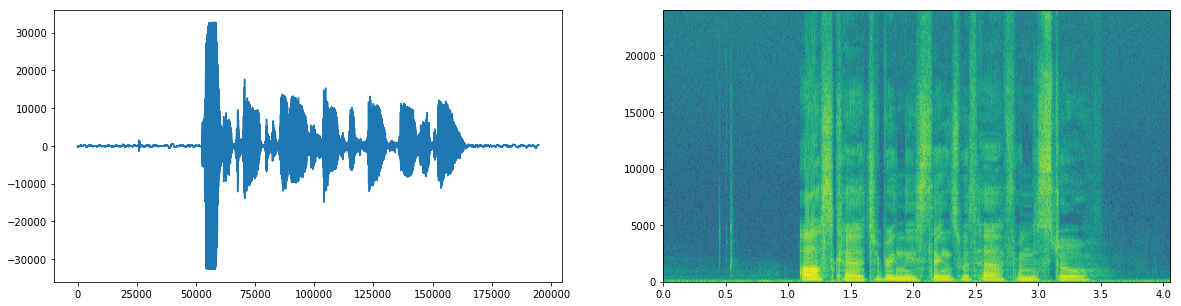

audio file


In [58]:
filename = './p225/wav/p225_002.wav'
f_s, sig = wav.read(filename)
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(sig)
plt.subplot(122)
plt.specgram(sig, NFFT=512, Fs=f_s)
plt.show()
print('audio file')
display(Audio(data=sig, rate=f_s))

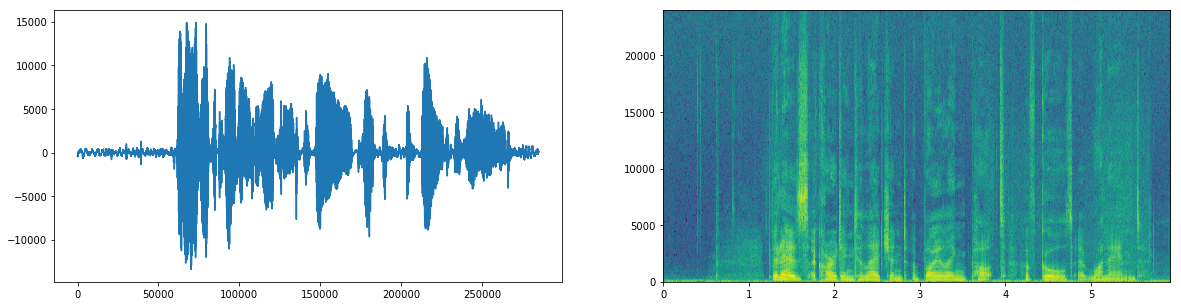

audio file


In [62]:
filename = './p262/wav/p262_009.wav'
f_s, sig = wav.read(filename)
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(sig)
plt.subplot(122)
plt.specgram(sig, NFFT=512, Fs=f_s)
plt.show()
print('audio file')
display(Audio(data=sig, rate=f_s))

The spectrogramms do not represent exaclty the kind of data that we will use to do classification but they enable a better visualization. We can hear good intonation differences between those two accents. The spectrograms show also the differences in frequency on pitches.
##  1. Load files an compute the mfcc features
To save compuation time, I fitted each Hidden Markov Model class (speaker accent) in the same for loop as the loading.

This code does :
- Loads each audio file
- Remove mean and normalize
- Compute mfcc features
- Save new dataset in array
- for HMMs
    - saves it either to training or testing set (10% in testing)
    - fits a hidden markov model for each accent

In [5]:
X_train = []
X_test = []
spkr_label_train = []
spkr_label_test = []
lengths = []
models = []

total_data = []
total_label = []

path = 'selected/'
speakers = sorted(os.listdir(path))
for speaker in speakers:
    if os.path.isdir(path+speaker): # this line allows the algorithm to avoid .DS_store files
        dir = sorted(os.listdir(path+speaker))
        lengths = []
        speaker_accent = []
        for audio_file in dir:
            
            fs, sig = wav.read(path + speaker + '/' + audio_file)
            
            # remove mean and normalize
            sig = sig - np.mean(sig)
            sig /= max(sig)
            
            # remove silences
            #sig = silence_remover(sig, fs)
            
            mfcc_feats = speechpy.mfcc(sig,fs)
            
            total_data.append(mfcc_feats)
            total_label.append(speaker)
            
            if audio_file == dir[-1] or audio_file == dir[-2]:
                # 2 audio files per speaker -> test set = 10% initial dataset
                X_test.append(mfcc_feats)
                spkr_label_test.append(speaker)
            else:
                X_train.append(mfcc_feats)
                spkr_label_train.append(speaker)
                speaker_accent.append(mfcc_feats)
                lengths.append(np.shape(mfcc_feats)[0])
                
        # For each speaker fit a hidden Markov Model on his accent       
        model = hmm.GaussianHMM(n_components=5, covariance_type='diag').fit(np.row_stack(speaker_accent), lengths)
        models.append((model, speaker)) # append this model with the speaker's name as the label
        model = None
        
        le.fit(total_label) # encode labels for plots and classification
        le_labels = le.transform(total_label) 
        le_labels.shape

## 2. Hidden Markov Model's highest score classification

In [7]:
def HMMpredictAccent(X_test, spkr_label_test, models):
    # this function loops over a set of hidden markov models to find the one that corresponds the most to 
    # the input speech. The one with the highest scor is set as the prediction.
    # input :
    #   - X_test : speeches to predict the accent size(13,?)
    #   - models : List of HMM models
    # Outputs : 
    #   - accuracy : accuracy over the testing set X_test
    #   - output_label : array of the length of X_test returning the predicted labels
    
    accuracy = 0
    output_label = []
    # loop over all testing speeches
    for i,a_speech in enumerate(X_test):
        max_score = [float("-inf")]

        for accent_model in models:
            model, label = accent_model
            score = model.score(a_speech)
            if score > max_score:
                max_score = score
                o_label = label
        
        output_label.append(o_label)
        if spkr_label_test[i] == output_label[i]:
            accuracy += 1
            
    accuracy /= len(X_test)
    print('accuracy = '+str(accuracy))
    
    return accuracy, output_label

In [8]:
accuracy, output_label = HMMpredictAccent(X_test, spkr_label_test, models)

accuracy = 0.9333333333333333


Normalizing and standardizing the data increased the HMM model accuracy by 3%. 

## 3. Reducing dimensionallity of the data into a statistical subspace
In order to reduce the dimensionality and fix the dimensionality of our data, we will make a few statistics.
For each mfcc feature, we will compute the mean, the std and the median values. This will create 13 * 3 = 39 features for a dataset of 300 datapoints.

In [236]:
from scipy import stats
New_data = np.ndarray([np.shape(total_data)[0], 13*3])
for i,mfcc_speech in enumerate(total_data):
    New_data[i,:13] = np.mean(mfcc_speech, axis=0)
    New_data[i,13:26] = np.std(mfcc_speech, axis=0)
    New_data[i,26:39] = np.median(mfcc_speech, axis=0)
    #New_data[i,39:52] = np.max(mfcc_speech, axis=0)
    #New_data[i,52:65] = stats.kurtosis(mfcc_speech, axis=0)
    #New_data[i,52:65] = stats.skew(mfcc_speech, axis=0)
# The next thing to do is to normalize and standardize the data
New_data -= New_data.mean(axis=0)
New_data /= New_data.std(axis=0)
New_data.shape

(300, 39)

## 4. Try basic PCA separation

In [10]:
from sklearn.decomposition import PCA
# get test and train set
X_test_shf, X_train_shf, y_test_shf, y_train_shf = get_train_test_set(New_data, le_labels, perc_for_test=0.2)

pca = PCA(15)
pca.fit(X_train_shf, y_train_shf)
pcaed = pca.transform(X_test_shf) # transform 29 dimensional dataset into 15d pca space
pca_output = np.reshape(np.argmax(pcaed, axis=1),[15,4]) # return index of highest value out of the 15 for each speech
pca_output # there are 4 speeches per speaker in the test set

array([[ 7,  0,  1,  4],
       [ 3,  8,  0,  8],
       [ 5, 13,  4,  0],
       [ 3,  0,  6,  0],
       [14,  3,  6,  8],
       [ 9,  8,  1, 10],
       [ 4,  0,  3, 11],
       [ 6,  3,  0,  1],
       [ 9, 11,  3,  7],
       [ 1,  1, 11,  0],
       [ 0,  0,  0,  0],
       [ 4,  5,  3,  4],
       [ 1,  5, 11,  3],
       [ 5,  4,  1, 14],
       [ 1,  0,  1,  9]])

To check if the PCA would give any interesting results, we applied the PCA on the train set and kept the 15 first eigenvectors, then transformed the test set to the fitted subspace. Then by transforming the test set to the newly created subspace, we checked whether the accents were splitting to specific dimensions. If the PCA makes the data seperable, then with 15 eigenvectors we should be able to give 15 "accent directions". 
We set as the PCA output the index of the dimension in which each speech is most represented, hence the output is the index of the maximum value out of the 15 dimensions. 
The output of the PCA classification shows great variablility in the main direction of the speeches per speaker. Hence, we can stop here with PCA and try more sophisticated techniques.
## 5. Spectral graph clustering
### 5.1 Compute the distance matrix between all spoken sentences
Here we construct a matrix of similarities between the speeches. This will be used to construct a graph and later on do clustering.

The distance used to compute the similarity matrix is the cosine distance. The cosine distance measures the angle between two points, the distance is minimum if the two points aim in the same direction in the space of the features.

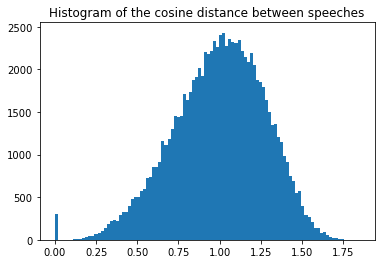

In [243]:
from scipy.spatial import distance
from scipy import sparse
distance_matrix = distance.squareform(distance.pdist(New_data, metric='cosine'))
distance_matrix.shape
plt.hist(distance_matrix.reshape(-1), bins=100);
plt.title('Histogram of the cosine distance between speeches')

### 5.2 Gaussian kernel and sparsification of the similarity matrix
In order to construct a graph of similarities and later cluster the data, we will use the gaussian kernel such that speeches that have a distance close to zero have strong edges and those close to 2 have weak edges.  

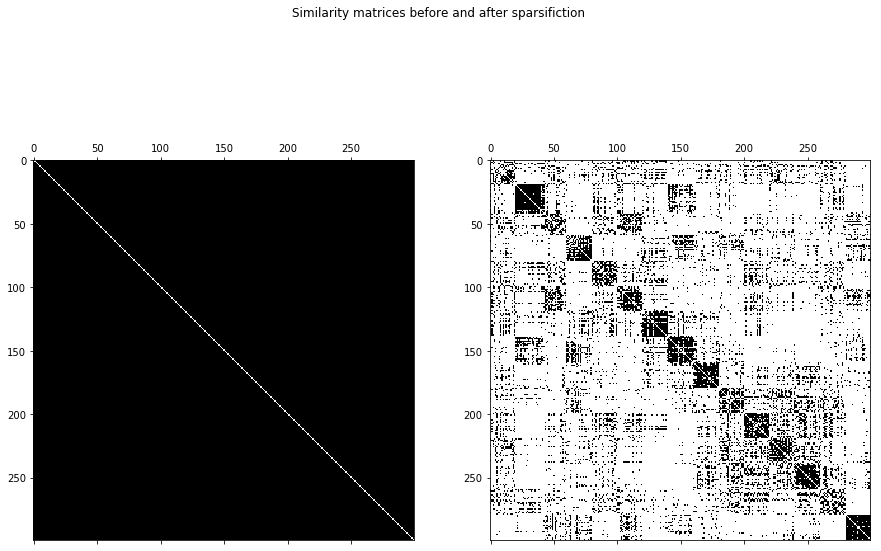

In [244]:
kernel_width = distance_matrix.mean()
weights = np.exp(-distance_matrix**2 / kernel_width**2)
# fill diagonal values with 0 such that we do not have strong auto edges
np.fill_diagonal(weights, 0)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.suptitle('Similarity matrices before and after sparsifiction')
axes[0].spy(weights)

neighbors = 40
idx = np.argsort(weights)[:, :-neighbors]
for i in range(weights.shape[0]):
    weights[i, idx[i, :]] = 0
weights = np.maximum(weights, weights.T)

axes[1].spy(weights)


Now that our matrix has been sparsified, can see on the top right 15 squares. This means that the accents should be seperable in this subspace. The sparsified matrix shows that **speaker one, two and fourteen will certainly be the hardest to classify in this subspace.**

### 5.3 Compute Laplacian

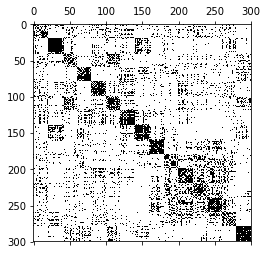

In [245]:
# Normalized Laplacian.
degrees = weights.sum(0)
deg_inv = np.diag(1 / np.sqrt(degrees))
I = scipy.sparse.identity(deg_inv.size, dtype=weights.dtype)
L = np.identity(weights.shape[0]) - deg_inv @ weights @ deg_inv

plt.spy(L);

In [246]:
L = sparse.csr_matrix(L)
n_edges = L.nnz - L.shape[0]
print('{} edges left out of {} x {} = {}, ({:.2%} were kept) '.format(n_edges, *weights.shape, weights.size, n_edges/weights.size))

14144 edges left out of 300 x 300 = 90000, (15.72% were kept) 


### 5.4 Get eigenvectors of the laplacian

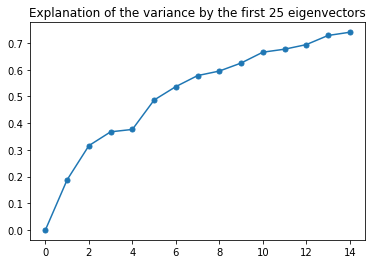

In [247]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(L, k=15, which='SM')
plt.plot(eigenvalues, 'o-', markersize=5);
plt.title('Explanation of the variance by the first 25 eigenvectors')

This plot shows that by keeping the 25 first eigenvectors, we still explain 85% of the variance.

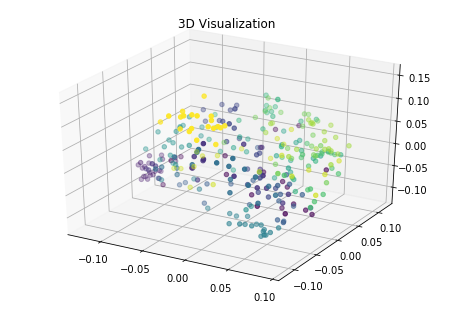

In [248]:
x = eigenvectors[:, 1]
y = eigenvectors[:, 2]
z = eigenvectors[:, 3]

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D

# 3D Visualization
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z, c=le_labels)
pylab.title('3D Visualization')
plt.show()

The 3D visualization of the datapoints show four main groups. It is however not possible to correctly discriminate more than four accent trends on this 3 dimensional space.
### 5.5 Cluster the accents 
as kmeans assigns centroids to datapoints, the number of the centroid counts as the label. To be able to compute the accuracy, the most recurrent centroid in the list of speeches from each speaker is set as the label of this accent. (ex : [2,3,4,4,4,1,6] -> the centroid corresponding to this accent is the fourth)

In [127]:
from scipy.cluster.vq import kmeans2
from statistics import mode

# Apply kmeans on the dataset (in the eigenvectors space)
_,clusters = kmeans2(eigenvectors, 15, iter=20, thresh=1e-05, check_finite=True)
# get maximum recurence of centroids
accent_class = [mode(x) for x in np.split(clusters,15)]
clusters = clusters.reshape([15,20])
accent_class

[0, 3, 10, 12, 7, 10, 13, 6, 2, 11, 8, 9, 4, 1, 5]

Because Kmeans is a very initialization sensitive algorithm, each run won't give the same results. I kept a run that showed only two classes with the same centroid. If the user wants to run the code, he should run the code as well to realls see the effect of initialization on kmeans results.

In [128]:
def solve_conflict_class(data, index_1, index_2, number, accent_class):
    # TODO
    if list(data[index_1,:]).count(10) > list(data[index_2,:]).count(number):
        looser_index = index_2
    else:
        looser_index = index_1 

    remove_10s = [val for val in list(data[looser_index,:]) if val != number]
    accent_class[looser_index] = mode(remove_10s)
    return accent_class

accent_class = solve_conflict_class(clusters, 2, 5, 10, accent_class)
print(accent_class)

[0, 3, 14, 12, 7, 10, 13, 6, 2, 11, 8, 9, 4, 1, 5]


In [129]:
accuracy = 0
for i,clusterized in enumerate(clusters):
    accuracy += list(clusterized).count(accent_class[i])
accuracy /= 300
accuracy

0.69

Spectral graph clustering gives an accuracy of 69%. The algorithm clearly found how to discriminate the accents but the limitations of unsupervised clustering do not allow us to classify more precisely accents. Let's try supervised classification.
## 6. Traditional classifiers
### 6.1 Shuffle the data and split it into a training and a testing set

In [258]:
X_test_shf, X_train_shf, y_test_shf, y_train_shf = get_train_test_set(New_data, le_labels, perc_for_test=0.2)
X_train_shf.shape

(240, 39)

### 6.2 Classify with a 5fold cross-validation
First we split our training set into five folds for cross validation.

In [259]:
# Creat 5 folds for Cross Validation
num_folds = 5 
X_train_folds = np.array_split(X_train_shf, num_folds)
y_train_folds = np.array_split(np.array(y_train_shf), num_folds)

In [260]:
import sklearn
import sklearn.neighbors, sklearn.linear_model, sklearn.ensemble, sklearn.naive_bayes 


accuracy_tab = np.zeros(num_folds)
model = []
for i, fold_idx in enumerate(range(num_folds)):

    # Extract train dataset for the current fold
    fold_x_train = np.concatenate([X_train_folds[i] for i in range(num_folds) if i!=fold_idx])       
    fold_y_train = np.concatenate([y_train_folds[i] for i in range(num_folds) if i!=fold_idx])   
    
    # validation dataset for the current fold
    fold_x_val  = X_train_folds[fold_idx]
    fold_y_val  = y_train_folds[fold_idx]

    # Run classification model for the current fold
    #model = sklearn.naive_bayes.BernoulliNB()
    #model = sklearn.ensemble.RandomForestClassifier()
    #model = sklearn.svm.LinearSVC()
    #model = sklearn.neighbors.KNeighborsClassifier()
    #model = sklearn.linear_model.RidgeClassifier()
    model.append(sklearn.linear_model.LogisticRegression(C=20))
    model[i].fit(fold_x_train, fold_y_train)
    train_pred = model[i].predict(fold_x_train)
    valid_pred = model[i].predict(fold_x_val)
    
    train_accuracy = sklearn.metrics.accuracy_score(train_pred, fold_y_train); print('train_accuracy : ' + str(train_accuracy))
    accuracy = sklearn.metrics.accuracy_score(test_pred, fold_y_val)
    accuracy_tab[fold_idx] = accuracy
    
    test_accuracy = sklearn.metrics.accuracy_score(test_pred, fold_y_test); 
    accuracy = sklearn.metrics.accuracy_score(test_pred, fold_y_val)
print('Cross validation test fold accuracy (mean accuracy = '+str(np.mean(accuracy_tab))+'):')
print(accuracy_tab)

test_pred = [m.predict(X_test_shf) for m in model]
test_acc = [sklearn.metrics.accuracy_score(tp, y_test_shf) for ]
print('Test set accuracy = ' + str(sklearn.metrics.accuracy_score(test_pred, y_test_shf)))

train_accuracy : 1.0
train_accuracy : 1.0
train_accuracy : 1.0
train_accuracy : 1.0
train_accuracy : 1.0
Cross validation test fold accuracy (mean accuracy = 0.8625):
[ 0.85416667  0.89583333  0.85416667  0.85416667  0.85416667]
Test set accuracy = 0.8


When testing a few classifiers, we get a mean valid accuracy of 86% and test accuracy of 80% for the logistic regression classification with a C value of 20.
## 7. Classification using Neural Networks
Neural Networks are usually used on large datasets, hence cross-validation is generally not used here. However, in our case, we can afford to do cross-validation. For clarity on the jupyter notebooks, I decided to use keras rather than tensorflow. Keras is well suited for simple graphs as it works on top of tensorflow and has a higher level of abstraction.

In [232]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder


In [252]:
X = New_data
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(total_label)
y = encoder.transform(total_label)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(y)

### 7.1 Simple multi layer perceptron
Before trying complicated networks, let's do a simple two layer perceptron, it will have the following architecture :
    - Fully Connected layer [30 nodes]
    - Relu activation
    - Fully Connected layer [15 nodes]
    - Softmax activation

In [253]:
# define convolutional neural network
def mlp_model():
    # create model
    model = Sequential()
    model.add(Dense(30, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(15, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [254]:
mlp_estimator = KerasClassifier(build_fn=mlp_model, epochs=200, batch_size=50, verbose=0)
kfold = KFold(n_splits=3, shuffle=True, random_state=1)
results = cross_val_score(mlp_estimator, X, y, cv=kfold)
print("mlp accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

mlp accuracy: 84.67% (1.25%)


The two layer perceptron, gives an accuracy of 84.67% on the statistical subspace (New_ata)
### 7.2 Classification with convolutional neural networks
For the convolutional neural network, we will use the raw data. To be able to input the dataset in the tensor, datapoints need to have the same number of features, hence we will cut the speeches into the size of the smallest speech of the dataset. The dataset will be the image created by the 13 mfcc features over the number of frames.

(An optimization could have been to set the number of frames the the one that creates the least amount of zero padding)

In [94]:
# Get the length of the smallest sentence and initilize new array
print('size of dataset : '+str(np.shape(total_data)))
length = len(min(total_data, key=len))
X_c = []
labels = []

# Loop over all speeches and cut them in smaller speeches
for i,a_speech in enumerate(total_data):
    # number of cuts 
    nb_datapts = int(np.ceil(len(a_speech)/length))
    
    for j in range(0,nb_datapts-1):
        new_datapt = a_speech[j*length:(j+1)*length,:]
        X_c.append(new_datapt)
        labels.append(total_label[i][1:])
        
    # Whether this new datapoints needs zero padding or not, the following lines will handle it correctly
    last_datapt = np.zeros([length,13])
    last_datapt[:a_speech[(nb_datapts-1)*length:,:].shape[0],:] =  a_speech[(nb_datapts-1)*length:,:]
    X_c.append(last_datapt)
    labels.append(total_label[i][1:])

# We expand the dimension in order to have a rank 4 tensor in the CNN
#X_c = np.expand_dims(np.array(X_c),axis=3)
X_c = np.array(X_c)
labels = np.array(labels)
print('New dataset size : ' + str(X_c.shape))
print(labels.shape)

size of dataset : (300,)
New dataset size : (840, 157, 13)
(840,)


In [217]:
encoder = LabelEncoder()
encoder.fit(labels)
# one hot encode the labels
onehot_labels = np_utils.to_categorical(encoder.transform(labels))

(672, 157, 13, 1)

Because of the small amount of datapoints that we have, there is no need to design a very deep network, it would make too many parameters to learn. Hence the network will have the following architecture :
    - convolution layer [30 feature maps, filter size 9, Relu Activation]
    - convolution layer [15 feature maps, filter size 9, Relu Activation]
    - Batch normalization
    - Dropout with a probability 0.25
    - Fully Connected layer [30 nodes, Relu Activation]
    - Dropout with a probability 0.5
    - Classifying Fully Connected layer [15 nodes]
    - Softmax activation


In [221]:
# define baseline model
nc = 15 # number of classes
batch_size = 50
def cnn_model():
    # create model
    model = Sequential()
    model.add(Conv1D(filters=2*nc, kernel_size=9, activation='relu', input_shape=[157,13]))
    model.add(Conv1D(filters=nc, kernel_size=9, activation='relu'))
    #print(model.output_shape)
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    # Fully Connected classifying layer
    model.add(Dense(2*nc, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nc, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model

cnn_estimator = KerasClassifier(build_fn=cnn_model, epochs=200, batch_size=100, verbose=0)

kfold = KFold(n_splits=3, shuffle=True, random_state=1)
results = cross_val_score(cnn_estimator, X_c, onehot_labels, cv=kfold)
print("cnn accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

cnn accuracy: 25.71% (0.58%)


The convolutional neural network does outputs great results. This is mainly due to the small amount of datapoints. However, using the whole Corpus as a dataset could highly increase the accuracy of the cnn and allow us to design deeper networks.
## Conclusion
This notebook showed simple techniques to classify english accents. The inclusion of all the Corpus dataset with the combination of a powerful GPU should allow the data scientist to design more sophisticated algorithms of classification. An open question should be answered to better recognize accents with machine. Could the accent be also discriminated from pauses or the amount of time spent in producing or forming strings of different phonemes ? 
### What could be done to increase the performance ?
 - Use a small function that detect silences at the beginning and end of each speech and remove those parts from the signal 
 - Add chroma features or short time energy features introduced in [1] 
 - Use more MFCC features.
 - Transform data in a lower dimensional space manifold.
 - Use only the vowels of the speeches to classify the accent. Extract the frequency values of only the first two peaks since they provide the most information in terms of what the vowel sound is. Since all vowels follow constant and recognizable patterns in these two formants, the changes along an accent can be recorded with a high degree of accuracy. [2]
 - Apply an eigenvoice adaptation, this techique relies on the assumption that all the pertinent variability is captured by a low rank rectangular matrix T named the Total variability matrix [4] [5]
 - language specific accent markers and simple formant features for classification [3]
 
An accent marker can be defined as a mark or syllable that emphasizes or accentuates certain stressed syllables or a spoken word.

### References :
[1] *S. B. Davies and P. Mermelstein. Comparison of parametric representations for monosyllabic word recognition in continuously spoken sentences. IEEE Transactions of Acoustics, Speech and Signal Processing, ASSP-28(4):357–366, August 1980.*

[2] *Accent Classification using Neural Networks http://cnx.org/content/col10320/1.1/*

[3] *Accent Classification in Speech, Shamalee Deshpande, Sharat Chikkerur, Venu Govindaraju Center for Unified Biometrics and Sensors, University at Buffalo*

[4] *Approaches to Language Identification using Gaussian Mixture Models and Shifted Delta Cepstral Featuresx,i
Pedro A. Torres-Carrasquillo1, 2, Elliot Singer2, Mary A. Kohler3, Richard J. Greene2, Douglas A. Reynolds2, and J.R. Deller, Jr.1*

[5] *Language Recognition via Ivectors and Dimensionality Reduction Najim Dehak1, Pedro A.Torres-Carrasquillo2, Douglas Reynolds2, Reda Dehak3*

[6] *Improving Language Recognition with Multilingual Phone Recognition and Speaker Adaptation Transforms*